## Imports

In [177]:
import numpy as np 
from numpy import linalg as LA
from scipy.linalg import norm
import matplotlib.pyplot as plt
import time
from numpy import *
import pandas as pd
from scipy.sparse import rand
import scipy.sparse as sparse

import glob
from PIL import Image
from IPython.display import Image as PyImage
from os import remove

from natsort import natsorted as ns

## Functions

In [169]:
def arnoldi_iteration(A, b, k, tol):
    Q = np.zeros((b.shape[0], k+1))
    H = np.zeros((k+1, k))
    Q[:, 0] = (b /np.linalg.norm(b, 2)).T

    eig_list = []
    
    for j in range(k-1):
        Q[:, j+1] = A @ Q[:, j]
        for i in range(j):
            H[i,j] = Q[:, i].T @ Q[:, j+1]
            Q[:, j+1] = Q[:, j+1] - H[i,j] * Q[:, i]
        
        H[j+1,j] = np.linalg.norm(Q[:, j+1], 2)

        # Append max eigenvalue
        eig_list.append(sorted(sparse.linalg.eigs(H[:-1, :])[0], reverse=True))
        
        if abs(H[j+1, j]) < tol:
            print("Converge !!")
            return Q[:, :j+1], H[:j+1, :j+1], eig_list
        
        Q[:, j+1] = Q[:, j+1]/H[j+1, j]
    
    return Q, H[:-1,:], eig_list

In [7]:
def relative_error(xnew, xold):
    return abs((xnew-xold)/xnew)*100

    
def power_method(A, b, iteration:100, eps = 1e-10):
    
    result = pd.DataFrame(columns=['eigenvalue', 'error']) # Create df result 
    eigenvalue = 0 # Inizialize eig
    oldeigenvalue = 0 # Inizialize old eig
    
    for i in range(iteration):
        
        b = A @ b # Multiply vector matrix 
        eigenvalue = np.linalg.norm(b) # Calcolate norm of eigenvalue
        b = b / eigenvalue  #Re normalize the vector
        error = relative_error(eigenvalue, oldeigenvalue) # Calcolate relative error between old an new eigh
        result.loc[i] = [eigenvalue, error] # Insert eigen and error to df 
        
        if error < eps: # Check accuracy 
            break
        
        oldeigenvalue = eigenvalue # Swap
    
    return result

In [179]:
def show_images(eig_list, u, column=5, fig_size=(5, 5)):
  min_e = np.min(eig_list)-10
  max_e = np.max(eig_list)+10
  for i in range(len(eig_list)):
    plt.ylim([min_e, max_e])
    plt.title(f"Iter: {i}")
    plt.plot(eig_list[i], 'o', color='r')
    plt.plot(u, 'o', color='g')

    plt.savefig(f"./gif_dir/{i}.jpg")
    plt.close()
    

def make_gif(frame_folder, duration):
  step = 500
  a = [image for image in glob.glob(f"{frame_folder}/*.jpg")]
  imgs = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.jpg")]
  for i in range(len(imgs)):
    plt.title('step: {}'.format(int(i)))
    plt.imshow(imgs[i], cmap='gray')
    plt.axis('off')
    plt.savefig(frame_folder + 'gif_dir/img_%d.jpg' % int(i))


  a = [image for image in glob.glob(f"{frame_folder + '/gif_dir'}/*.jpg")]
  frames = [Image.open(image) for image in ns(glob.glob(f"{frame_folder + '/gif_dir'}/*.jpg"))]
  print('frames: {}'.format(len(frames)))
  frame_one = frames[0]
  frame_one.save( "eigen_approx.gif", format="GIF",
              append_images=frames, save_all=True, duration=duration, loop=0)
  
  [remove(f) for f in a]

## **Tests**

In [170]:
dim = 1000
A = sparse.random(dim, dim, density=1.)
b = np.random.random((dim,1))
# b

**Performe Arnoldi Iteration**

In [ ]:
Q, h, eig_list = arnoldi_iteration(A, b, 30, tol = 1e-10)
u = sparse.linalg.eigs(A)[0] #calculate real eigenvalue to compare with arnoldi approximation

#### **Making a GIF to see approximation error during iteration**

In [182]:
%%capture
show_images(eig_list, u)
make_gif("./", 500)

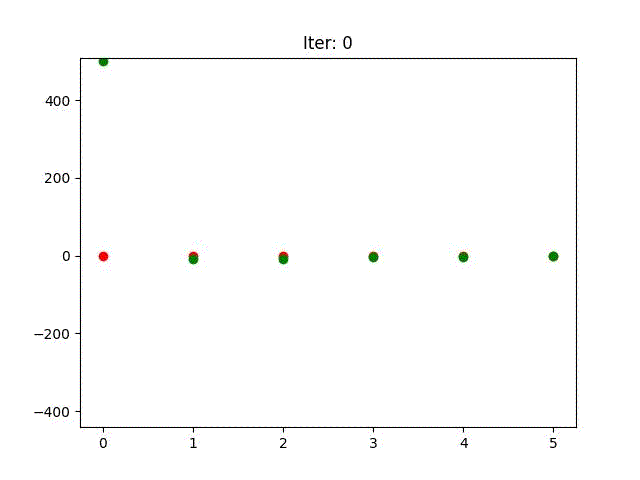

In [183]:
PyImage(filename='eigen_approx.gif')

#### **Numerical visualization**

In [12]:
u, v = sparse.linalg.eigs(A)
u_h, v_h = sparse.linalg.eigs(h)

u = sorted(u, reverse=True)
u_h = sorted(u_h, reverse=True)

print(u)
print()
print(u_h)

[(500.29183606759153+0j), (6.6590894245323575-6.39805104046256j), (-7.991207065929768+4.691745845364334j), (-7.991207065929768-4.691745845364334j), (-9.186011712928437+1.1307902409621353j), (-9.186011712928437-1.1307902409621353j)]
[(500.2918360675926+0j), (72.90532665779341+0j), (16.965890217146452+0j), (-90.34317521204775+0j), (-118.31195664539108+0j), (-382.22864395192454+0j)]


#### **Test with a matrix conditioned**

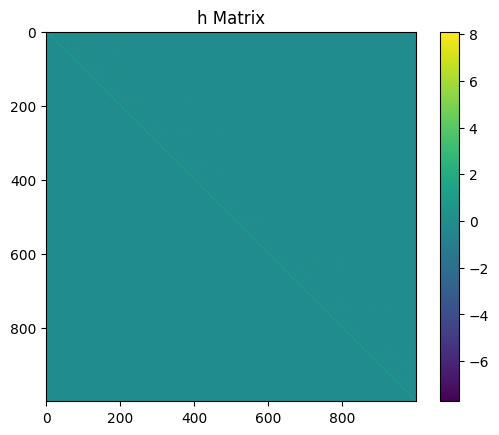

In [17]:
A = sparse.random(dim, dim, 1., dtype=np.float64)*0.01 + sparse.eye(dim,)*4
Q, h = arnoldi_iteration(A, b, 100, tol=1e-15)

plt.imshow(h)
plt.colorbar()
plt.title("h Matrix")
plt.show()


In [18]:
u, v = sparse.linalg.eigs(A)
u_h, v_h = sparse.linalg.eigs(h)

u = sorted(u, reverse=True)
u_h = sorted(u_h, reverse=True)

print(u)
print(u_h)

[(8.99977705589127+0j), (4.092419969669178+0j), (4.090861962922893+0j), (4.08823976590342+0.004514219318414645j), (4.08823976590342-0.004514219318414645j), (4.0880373027319195-0.012989488359181078j)]
[(8.999777055891274+0j), (4.09241996966896+0j), (4.0908619629227125+0j), (4.088037302732067-0.012989488359506987j), (-4.821643529467481+0j), (-7.820256348824868+0j)]


### **Power Method**

In [19]:
res = power_method(A, b, iteration=100, eps=1e-15)
eigen = (res['eigenvalue'])

In [24]:
res.iloc[-1]

eigenvalue    8.999777
error         0.000000
Name: 38, dtype: float64